In [ ]:
#scvi doesn't work without next 3
%pip install pymde
%pip install leidenalg
%pip install igraph
%pip install --quiet gdown
%pip install seaborn
%pip install --quiet bbknn
%pip install pandas
%pip install pyscenic
%pip install ipywidgets
%pip install MulticoreTSNE
%pip install scipy
%pip install scikit-misc
#if you're going to install pytorch or JAX for accelerated computing do it before scvi
%pip install scanpy
%pip install anndata
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install nvidia-cuda-runtime-cu12
%pip install nvidia-<library>
%pip install -U scvi-tools

Import packages

In [2]:
#general
import os
import glob
import tarfile
import numpy as np
import scanpy as sc
import pandas as pd

#pyscenic
import anndata as ad
from anndata.experimental.multi_files import AnnCollection
#specific requirements of pyscenic
import loompy as lp

## This is T-SNE, download has wheel error, could fix... could use UM
#from MulticoreTSNE import MulticoreTSNE as TSNE

#data vis
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import umap


#scvi
import leidenalg
import igraph
import pymde
import torch
import tempfile
import scvi

d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\anndata\utils.py:429: Futu

In [ ]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (2**30)} GiB")
print(f"Used: {used // (2**30)} GiB")
print(f"Free: {free // (2**30)} GiB")

In [ ]:

# Function to extract tar.gz files
def extract_tar_gz(tar_gz_path, extract_dir):
    with tarfile.open(tar_gz_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)

# Directory containing your datasets
input_dir = "input/biostudiesarrayE-MTAB-14039"
extracted_dir = "input/extracted_data"  # Folder to save the extracted files
os.makedirs(extracted_dir, exist_ok=True)

# List all top-level files in the input directory
tar_gz_files = [f for f in os.listdir(input_dir) if f.endswith('.tar.gz')]

# Extract tar.gz files
for tar_gz_file in tar_gz_files:
    tar_gz_path = os.path.join(input_dir, tar_gz_file)
    
    # Extract the tar.gz file to the extracted directory
    extract_tar_gz(tar_gz_path, extracted_dir)


In [ ]:

# Directory where the files have been extracted
extracted_work_dir = "input/extracted_data"  # Directory where you extracted the tar files
# List to store directory names under the 'work' directory
dataset_dirs = []

# Traverse the 'work' directory to find subdirectories
for root, dirs, files in os.walk(extracted_work_dir):
    # Only consider directories directly under the 'work' directory
    if "work" in root:
        for dir_name in dirs:
            path = os.path.join(root, dir_name)
            # Append the directory name under 'work'
            dataset_dirs.append(path)

# Now dataset_dirs contains the names of all subdirectories under 'work'
print("Dataset directories under 'work':", dataset_dirs)


In [ ]:
print(dataset_dirs)


Docs: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anncollection.html
https://ccbskillssem.github.io/assets/scvi_notebook.html

warning: "If you use join='outer' this fills 0s for sparse data when variables are absent in a batch. Use this with care. Dense data is filled with NaN."

https://discourse.scverse.org/t/how-to-concatenate-anndata-properly/887/2
strongly recommends datacleaning each dataset before concatenating -- assuming that they did it for us

In [ ]:

hd5a_files_directory = r"input/hd5a_files"
if not os.path.exists(hd5a_files_directory):
    os.makedirs(hd5a_files_directory) 
adatas_dict = {}
for directory in dataset_dirs:
    adata = sc.read_10x_mtx(directory)
    adata.X = adata.X.tocsr()
    #dir_name = directory.split("\\")[-1]
    dir_name = os.path.basename(directory) #platform independent
    h5ad_filename = f"{dir_name}.h5ad"

    h5ad_path = os.path.join(hd5a_files_directory, h5ad_filename)
    adata.write(h5ad_path)
    adatas_dict[dir_name] = h5ad_path


In [ ]:
print(adatas_dict)

In [ ]:
output_directory = r"output/"
combined_on_disk_name = os.path.join(output_directory, 'data_combined_on_disk.h5ad') 
#os.remove(combined_on_disk_name)
ad.experimental.concat_on_disk(
    adatas_dict,          # List of paths to the individual .h5ad files
    combined_on_disk_name,  # Path to the combined output file
    label='dataset'      # Optional: label for the datasets
)

In [ ]:
##METHOD USING BATCHING -- broken???
# # Directory where the files have been extracted
# extracted_work_dir = "input/extracted_data"  # Directory where you extracted the tar files
# # List to store directory names under the 'work' directory
# dataset_dirs = []

# # Traverse the 'work' directory to find subdirectories
# for root, dirs, files in os.walk(extracted_work_dir):
#     # Only consider directories directly under the 'work' directory
#     if "work" in root:
#         for dir_name in dirs:
#             path = os.path.join(root, dir_name)
#             # Append the directory name under 'work'
#             dataset_dirs.append(path)

# # Now dataset_dirs contains the names of all subdirectories under 'work'
# print("Dataset directories under 'work':", dataset_dirs)



# # List to store AnnData objects for merging
# adatas = []
# batch_size = 5  # Adjust based on available memory
# for i in range(0, len(dataset_dirs), batch_size):
#     # Get the current batch of files
#     batch_files = dataset_dirs[i:i+batch_size]
    
#     # Load the current batch of datasets
#     batch_adatas = []
#     for mtx_file in batch_files:
#         print(mtx_file)
#         # Assuming each batch is loaded from corresponding directories
#         adata = sc.read_10x_mtx(mtx_file)
#         batch_adatas.append(adata)
    
#     # Concatenate the current batch
#     if adatas:
#         adatas[0] = ad.concat([adatas[0]] + batch_adatas)
#         adatas[0].obs_names_make_unique() 
#     else:
#         adatas = batch_adatas

#     # Free memory by clearing the batch Adatas
#     batch_adatas = []

Load in data -- OLAF's VERSION. Garrett Depending on what you did you made need to make a different block.

Data Exploration

In [ ]:
combined_adata = sc.read("output/data_combined_on_disk.h5ad")
combined_adata.obs_names_make_unique()

In [ ]:
combined_adata.obs.head()


In [ ]:
import pandas as pd

#read text file into pandas DataFrame
df = pd.read_csv('input/E-MTAB-14039.sdrf.txt', sep='\t', comment='#', on_bad_lines='skip')
#print(df.columns)
healthy_tissue = df[df['Characteristics[disease]'] == 'normal']['Source Name']

print(len(healthy_tissue))

In [ ]:
#THIS WORKS BUT IS TOO SMALL
#combined_adata = combined_adata[~combined_adata.obs['dataset'].str.contains('Endo', na=False)]
combined_adata = combined_adata[combined_adata.obs['dataset'].isin(healthy_tissue)]
combined_adata.obs['dataset']

In [ ]:
#from scipy import sparse

#sparse_X = sparse.csr_matrix(combined_adata.X)
#combined_adata.X = sparse_X

In [ ]:


combined_adata.var.head()



In [ ]:
print(combined_adata.var_names)
combined_adata.X

In [ ]:
combined_adata.obs
#output_file = "output/integrated_data.h5ad"
#combined_adata.write(output_file) # might just be failing because it already exists

## Quality Control

In [ ]:
combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)


combined_adata.obs.head()



In [ ]:
sc.pl.violin(
    combined_adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

In [ ]:
sc.pl.scatter(combined_adata, "total_counts", "n_genes_by_counts")

In [ ]:
sc.pp.filter_cells(combined_adata, min_genes=100)
sc.pp.filter_genes(combined_adata, min_cells=3)

In [ ]:
#skipping, I don't think doublets make sense to detect with dataset that has already been processed and integrated.
#sc.pp.scrublet(combined_adata, batch_key="sample")

In [ ]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#combined_adata = sc.read("output/integrated_data.h5ad")

### Normalization

In [ ]:
combined_adata.layers["counts"] = combined_adata.X.copy()
sc.pp.normalize_total(combined_adata, target_sum=1e4) 
sc.pp.log1p(combined_adata) 
combined_adata.raw = combined_adata

In [ ]:
sc.pp.highly_variable_genes(
    combined_adata,
    n_top_genes=4000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)
sc.pl.highly_variable_genes(combined_adata, log=True)

In [ ]:
combined_adata = combined_adata[:, combined_adata.var.highly_variable].copy()
combined_adata.raw.to_adata()

In [ ]:
combined_adata.var.columns

# The .var attribute stores metadata related to variables (typically genes). 
#view with specific with
## adata.var['gene_type'].head()


In [ ]:
combined_adata.obs.columns
#The .obs attribute stores metadata related to the observations (cells). To see the available metadata columns:
#view with 
## adata.obs['cell_type'].head()

In [ ]:
combined_adata.uns.keys()
#The .uns attribute contains unstructured annotations that may include
#  clustering results, embeddings, or other metadata that doesn’t fit neatly into .obs or .var. 

In [ ]:
print(combined_adata.layers.keys())

### Standard Workflow

In [ ]:
sc.pp.scale(combined_adata) # z normalize the columns (genes)
sc.tl.pca(combined_adata)


combined_adata.obsm["X_pca"]
sc.pp.neighbors(combined_adata) # compute nearest neighbors
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color="dataset")

IF THE CLUSTERS ARE BY BATCH:: ADD THIS CODE:

In [ ]:

import scanpy.external as sce
sce.pp.bbknn(combined_adata, batch_key="dataset")
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=["dataset"], ncols=1)
#don't know what this 'computation' warning is. No 'computation' parameter in bbknn or umap


In [2]:
#combined_adata.write("output/combined_with_umap_no_scvi.h5ad")
combined_adata = sc.read("output/combined_with_umap_no_scvi.h5ad")
combined_adata.obs.head()


,dataset,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,n_genes,_scvi_batch,_scvi_labels
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345,3737,15451.0,1092.0,7.067504,3737,0,0
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345,2225,4539.0,212.0,4.670632,2225,0,0
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345,3379,11695.0,1544.0,13.202223,3379,0,0
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345,2307,6950.0,700.0,10.071942,2307,0,0
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345,2487,7820.0,658.0,8.414322,2487,0,0


IF IT STILL DOESN'T WORK THEN REDO THE LOAD IN AND USE SCIVI
https://ccbskillssem.github.io/assets/scvi_notebook.html

https://www.youtube.com/watch?v=EKTg9NV5hEA

In [3]:

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
#save_dir = tempfile.TemporaryDirectory()
save_dir = 'output/scvi_checkpoints' 
#%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
#%config InlineBackend.figure_format="retina"

In [4]:
!nvidia-smi

Fri Nov 22 13:26:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:02:00.0 Off |                  N/A |
|  0%   34C    P8              9W /  185W |    1440MiB /   8192MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:


print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
	
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

#Garrett if this is false for you -- 
## run this in powershell (assuming windows/pip/python): pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
## OR just comment out the next block rewrite it without the accelerator. It will take longer

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1070


In [6]:
scvi.settings.seed = 0
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


In [ ]:

print(scvi.__version__)
# Set up the AnnData object (combined_adata)
scvi.model.SCVI.setup_anndata(combined_adata, layer="counts", batch_key='dataset')

# Initialize the SCVI model
model = scvi.model.SCVI(combined_adata) #, n_layers=2, n_latent=30, gene_likelihood="nb"

# Set the number of workers for data loading
scvi.settings.dl_num_workers = 0 #default is 0, gives warnings to raise but then gives iter(combined_loader) errors
# Train the model, specifying the accelerator (GPU or CPU)


1.2.0


In [8]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [9]:
print(str(combined_adata))
print(combined_adata.layers)

AnnData object with n_obs × n_vars = 135489 × 4000
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
Layers with keys: counts


In [12]:
model.train() 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training:   0%|          | 0/59 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=59` reached.


In [13]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [14]:
SCVI_LATENT_KEY = "X_scVI"
combined_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [15]:

sc.pp.neighbors(combined_adata, use_rep=SCVI_LATENT_KEY)

In [16]:

sc.tl.leiden(combined_adata)

C:\Users\Olaf\AppData\Local\Temp\ipykernel_4348\887063886.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined_adata)


In [ ]:
SCVI_MDE_KEY = "X_scVI_MDE"
combined_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(combined_adata.obsm[SCVI_LATENT_KEY]) #last run was with , accelerator="cpu" but I removed this so that it can use gpu, return if breaks

INFO     Using cpu for `pymde.preserve_neighbors`.                                                                 


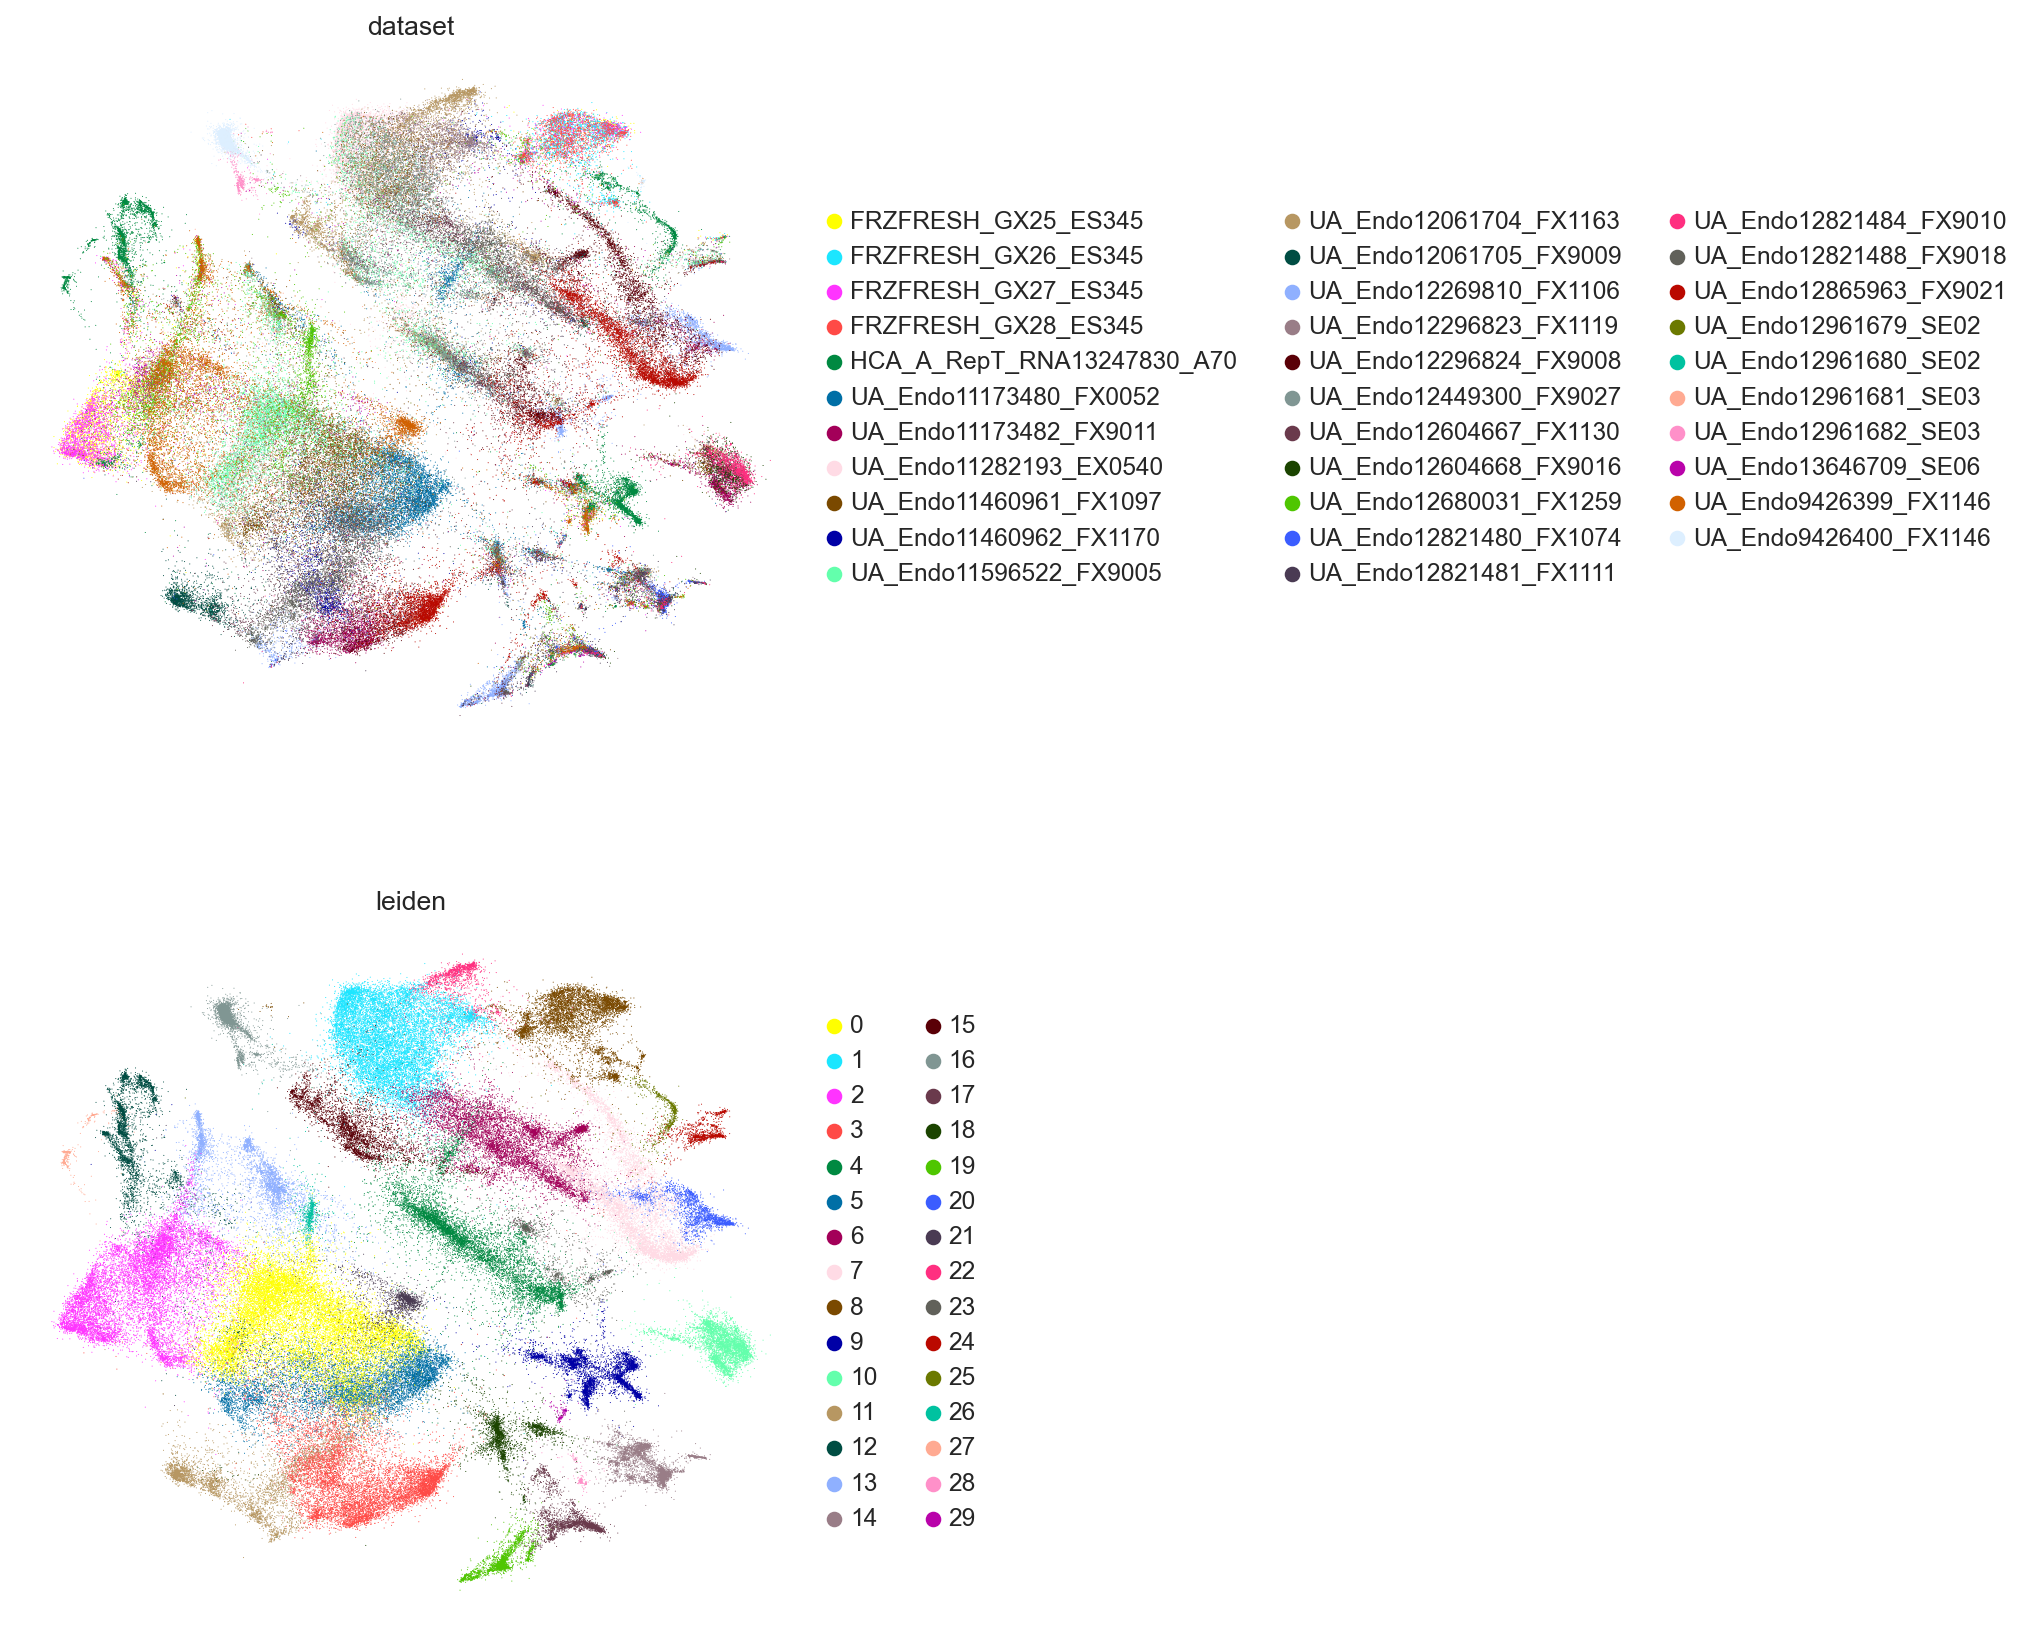

In [18]:
sc.pl.embedding(
    combined_adata,
    basis=SCVI_MDE_KEY,
    color=["dataset", "leiden"],
    frameon=False,
    ncols=1,
)

In [12]:
output_file = "output/scvi_integrated.h5ad"
#combined_adata.write(output_file)
combined_adata = sc.read(output_file)


## SCENIC

scvi and and pySCENIC may be incompatible.
pySCENIC requires numpy 2.0> and scvi requires numpy <2.0

In [ ]:
!pip install git+https://github.com/aertslab/pySCENIC.git

In [13]:
from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

Download tf motifs from 
wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl
https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20List%20of%20Transcription%20Factors.ipynb


In [14]:
BASEFOLDER_NAME = 'Input/tf_motifs/'

MOTIFS_HGNC_FNAME = os.path.join(BASEFOLDER_NAME, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
OUT_TFS_HGNC_FNAME = os.path.join(BASEFOLDER_NAME, 'hs_hgnc_tfs.txt')

df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')
hs_tfs = df_motifs_hgnc.gene_name.unique()
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_tfs) + '\n')
len(hs_tfs)

C:\Users\Olaf\AppData\Local\Temp\ipykernel_8968\2715623596.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')


1839

In [15]:
df_motifs_hgnc.head()

,#motif_id,motif_name,motif_description,source_name,source_version,gene_name,motif_similarity_qvalue,similar_motif_id,similar_motif_description,orthologous_identity,orthologous_gene_name,orthologous_species,description
0,bergman__Abd-B,Abd-B,Abd-B,bergman,1.1,HOXA9,0.0006,cisbp__M1008,"HOXA6[gene ID: ""ENSG00000106006"" species: ""Hom...",0.981618,ENSMUSG00000038227,M. musculus,gene is orthologous to ENSMUSG00000038227 in M...
1,bergman__Aef1,Aef1,Aef1,bergman,1.1,ZNF8,0.0000,NaN,NaN,0.213656,FBgn0005694,D. melanogaster,motif is annotated for orthologous gene FBgn00...
2,bergman__Cf2,Cf2,Cf2,bergman,1.1,ZNF853,0.0000,NaN,NaN,0.150980,FBgn0000286,D. melanogaster,motif is annotated for orthologous gene FBgn00...
3,bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1H2,0.0000,NaN,NaN,0.378261,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...
4,bergman__EcR_usp,EcR_usp,EcR/usp,bergman,1.1,NR1H3,0.0000,NaN,NaN,0.406181,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...


Download database from https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/ 

In [ ]:

DATABASE_FOLDER = "input/motif_database"
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(DATABASE_FOLDER, fn),
                       ['hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                       'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather',
                        'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                        'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather']))
RANKING_DBS_FNAMES

In [22]:
DATASET_ID = "HECA14039"
RESULTS_FOLDERNAME = "output/results"
EXP_MTX_QC_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.qc.tpm.csv'.format(DATASET_ID))


In [ ]:
!pyscenic grn {EXP_MTX_QC_FNAME} {HUMAN_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 4

['input/motif_database\\hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
 'input/motif_database\\hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather',
 'input/motif_database\\hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
 'input/motif_database\\hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather']

In [7]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

NameError: name 'RankingDatabase' is not defined

##### STEP 1: IDENTIFY TF with arboreto 


In [22]:
f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt"

!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')
adjacencies.head()

d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\pyscenic\transform.py:42: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  ("Enrichment", COLUMN_NAME_ANNOTATION): np.object,
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Coding\comp_bio\endometrial_analysis\.venv\Scripts\pyscenic.exe\__main__.py", line 4, in <module>
  File "d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\pyscenic\cli\pyscenic.py", line 26, in <module>
    from pyscenic.prune import _prepare_client, find_features, prune2df
  File "d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\pyscenic\prune.py", line 27, in <module>
    from .transform import (
  File "d:\Coding\comp_bio\endometrial_analysis\.venv\Lib\site-packages\pyscenic\transform.py", line 42, in <module>
    ("Enrichment", COLUMN_NAME_ANNOTATION): np.object,
          

FileNotFoundError: [Errno 2] No such file or directory: 'adj.tsv'

##### STEP 2: Refine regulons through pruning 

In [ ]:

# ranking databases
f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

##### STEP 3: Cluster cells around regulons

In [ ]:
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

#### STEP 4 Integrate the Output --- THIS LOOKS PROBLEMATIC AND VERY NOT RIGHT

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']